##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [10]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Pose Landmarks Detection with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to detect pose landmarks from images.

## Preparation

Let's start with installing MediaPipe.


In [1]:
!pip install -q mediapipe

Then download an off-the-shelf model bundle. Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/pose_landmarker#models) for more information about this model bundle.

In [2]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

In [3]:
# 定義人體骨架連線 (點對點)
POSE_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5), (5, 6), (6, 8), (9, 10),
    (11, 12), (11, 13), (13, 15), (15, 17), (15, 19), (15, 21), (17, 19),
    (12, 14), (14, 16), (16, 18), (16, 20), (16, 22), (18, 20), (11, 23),
    (12, 24), (23, 24), (23, 25), (24, 26), (25, 27), (26, 28), (27, 29),
    (28, 30), (29, 31), (30, 32), (27, 31), (28, 32)
]

In [4]:
import cv2
import numpy as np

def draw_landmarks_on_image(rgb_image, detection_result):
    if not detection_result or not detection_result.pose_landmarks:
        return rgb_image

    annotated_image = np.copy(rgb_image)
    height, width, _ = annotated_image.shape

    for pose_landmarks in detection_result.pose_landmarks:
        # 1. 取得所有點的像素座標
        pixel_landmarks = []
        for landmark in pose_landmarks:
            px = int(landmark.x * width)
            py = int(landmark.y * height)
            pixel_landmarks.append((px, py))

            # 畫出關鍵點 (小圓點)
            cv2.circle(annotated_image, (px, py), 5, (0, 255, 0), -1)

        # 2. 畫出骨架連線
        for connection in POSE_CONNECTIONS:
            start_idx = connection[0]
            end_idx = connection[1]

            # 確保索引在範圍內且可信度足夠 (選擇性)
            cv2.line(annotated_image,
                     pixel_landmarks[start_idx],
                     pixel_landmarks[end_idx],
                     (255, 255, 255), 2)

    return annotated_image

## Visualization utilities

## Download test image

To demonstrate the Pose Landmarker API, you can download a sample image using the follow code. The image is from [Pixabay](https://pixabay.com/photos/girl-woman-fitness-beautiful-smile-4051811/).

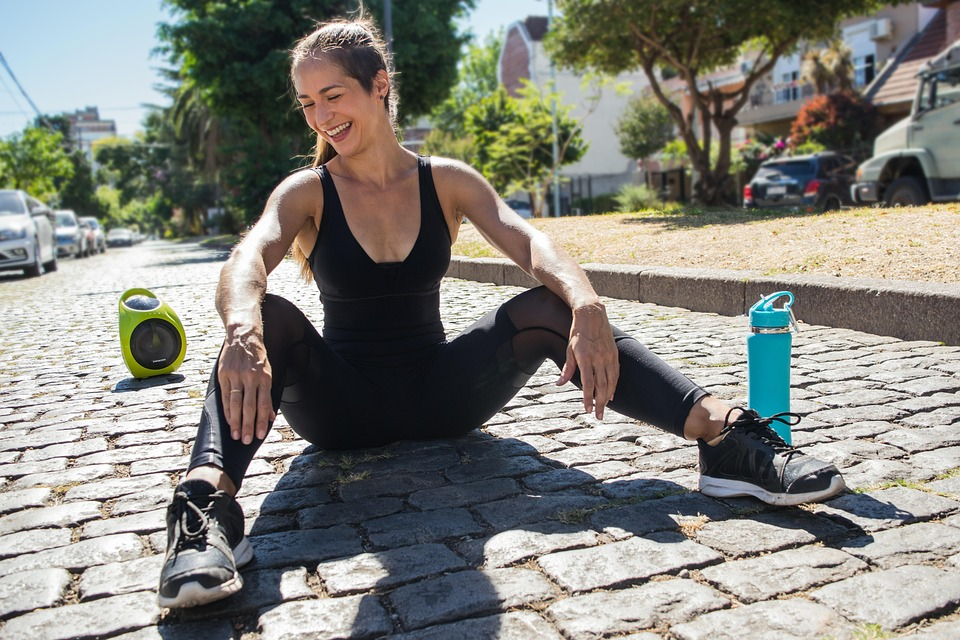

In [5]:
!wget -q -O image.jpg https://cdn.pixabay.com/photo/2019/03/12/20/39/girl-4051811_960_720.jpg

import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread("image.jpg")
cv2_imshow(img)

Optionally, you can upload your own image. If you want to do so, uncomment and run the cell below.

In [6]:
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded:
#   content = uploaded[filename]
#   with open(filename, 'wb') as f:
#     f.write(content)

# if len(uploaded.keys()):
#   IMAGE_FILE = next(iter(uploaded))
#   print('Uploaded file:', IMAGE_FILE)

## Running inference and visualizing the results

The final step is to run pose landmark detection on your selected image. This involves creating your PoseLandmarker object, loading your image, running detection, and finally, the optional step of displaying the image with visualizations.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/pose_landmarker/python) to learn more about configuration options that this solution supports.


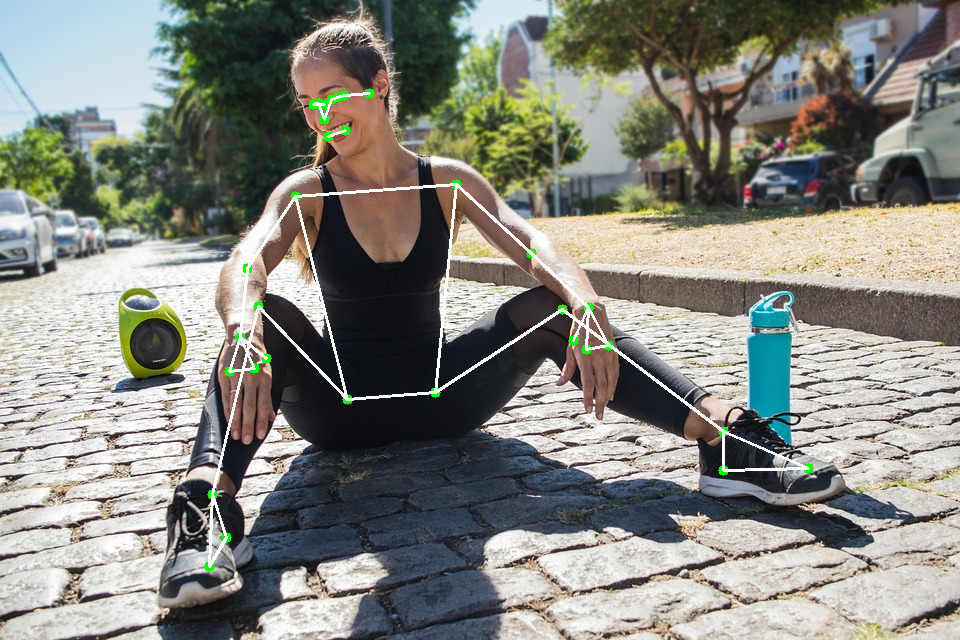

In [7]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("image.jpg")

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

Visualize the pose segmentation mask.

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# 1. 定義連線 (33個節點的標準骨架)
POSE_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5), (5, 6), (6, 8), (9, 10),
    (11, 12), (11, 13), (13, 15), (15, 17), (15, 19), (15, 21), (17, 19),
    (12, 14), (14, 16), (16, 18), (16, 20), (16, 22), (18, 20), (11, 23),
    (12, 24), (23, 24), (23, 25), (24, 26), (25, 27), (26, 28), (27, 29),
    (28, 30), (29, 31), (30, 32), (27, 31), (28, 32)
]

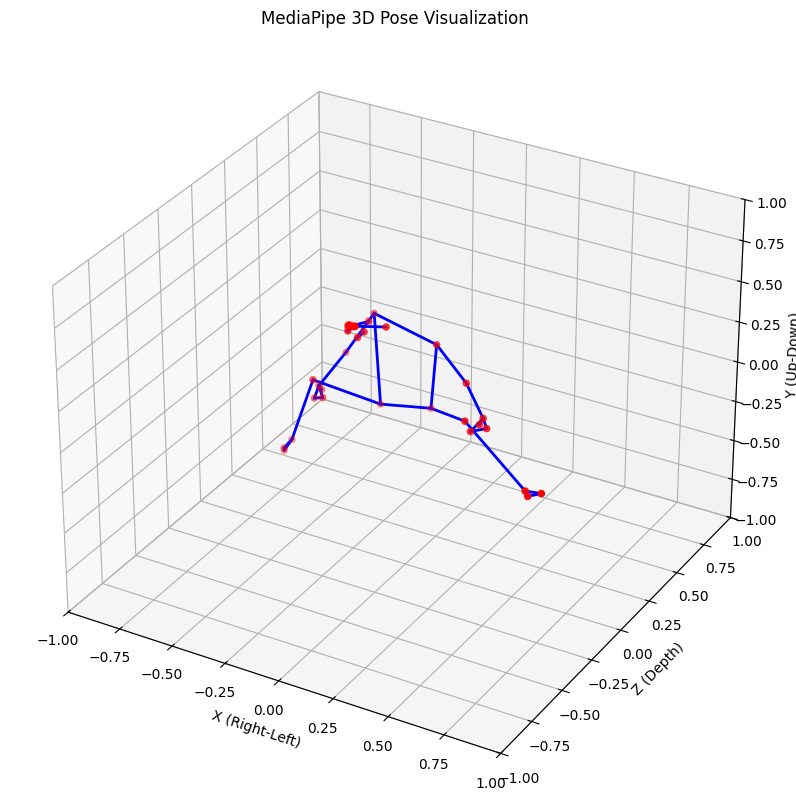

3D 圖表已生成。


In [10]:
def plot_3d_pose(detection_result):
    # 檢查是否有資料
    if not detection_result or not detection_result.pose_world_landmarks:
        print("未偵測到 3D 世界座標，請確認影像中有人體且模型正確載入。")
        return

    # 建立一個互動式 3D 畫布
    plt.ion() # 開啟互動模式
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # 取得第一個人的 3D 世界座標 (公尺)
    world_landmarks = detection_result.pose_world_landmarks[0]

    # MediaPipe World Landmarks 座標系:
    # X: 右為正, Y: 下為正 (故需取負值), Z: 前為正 (離相機近為負)
    xs = [lm.x for lm in world_landmarks]
    ys = [lm.z for lm in world_landmarks] # 將 Z 映射到 3D 圖的 Y 軸
    zs = [-lm.y for lm in world_landmarks] # 將 Y 映射到 3D 圖的 Z 軸 (取負讓頭部向上)

    # 1. 畫出關鍵點
    ax.scatter(xs, ys, zs, c='red', marker='o', s=20)

    # 2. 畫出骨架連線
    for connection in POSE_CONNECTIONS:
        start_idx, end_idx = connection
        ax.plot([xs[start_idx], xs[end_idx]],
                [ys[start_idx], ys[end_idx]],
                [zs[start_idx], zs[end_idx]], c='blue', linewidth=2)

    # 3. 設定座標軸範圍 (大約 1 公尺半徑，讓骨架比例正常)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)

    ax.set_xlabel('X (Right-Left)')
    ax.set_ylabel('Z (Depth)')
    ax.set_zlabel('Y (Up-Down)')
    plt.title('MediaPipe 3D Pose Visualization')

    # 確保視窗彈出
    plt.draw()
    plt.pause(0.001)
    print("3D 圖表已生成。")
    plt.show(block=True) # 這一行會卡住程式，直到你手動關閉視窗

# 調用方式範例:
plot_3d_pose(detection_result)